# Setup

In [ ]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 11.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Dataset

In [ ]:
import pandas as pd
cols = ['preprocess', 'label',
        'num_word', 'num_char', 'num_hashtag', 'num_url',
        'num_like_post', 'num_comment_post', 'num_share_post',
        'hour', 'weekday', 'day', 'month', 'year']
df = pd.read_csv('/content/drive/Shareddrives/[NCKH] /CODE/DATA/data_after_preprocessing_text_sa_timestamp_numeric.csv', usecols=cols)

In [ ]:
df = df.reindex(columns=cols)

In [ ]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106 entries, 0 to 4105
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   preprocess        4106 non-null   object 
 1   label             4106 non-null   int64  
 2   num_word          4106 non-null   int64  
 3   num_char          4106 non-null   int64  
 4   num_hashtag       4106 non-null   int64  
 5   num_url           4106 non-null   int64  
 6   num_like_post     4106 non-null   float64
 7   num_comment_post  4106 non-null   float64
 8   num_share_post    4106 non-null   float64
 9   hour              4106 non-null   int64  
 10  weekday           4106 non-null   int64  
 11  day               4106 non-null   int64  
 12  month             4106 non-null   int64  
 13  year              4106 non-null   int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 449.2+ KB
None


,preprocess,label,num_word,num_char,num_hashtag,num_url,num_like_post,num_comment_post,num_share_post,hour,weekday,day,month,year
0,cần các bậc phụ_huynh xã ngũ thái lên_tiếng kh...,1,34,182,0,0,45.0,15.0,8.0,6,1,17,3,2020
1,kêu_gọi ăn_chay cầu_nguyện xin chúa cứu khỏi d...,1,10,62,0,0,979.0,39.0,138.0,19,0,10,2,2020
2,giàn khoan dầu_khí gặp sự_cố chết người giàn k...,1,41,212,0,0,85.0,13.0,61.0,12,3,16,4,2020
3,thuận_lợi có ca dương_tính cv19 rồi đó mọi ngư...,1,28,151,0,0,114.0,12.0,5.0,10,0,3,8,2020
4,sa_pa cho 9 người khách nước_ngoài đi cùng chu...,1,13,65,0,0,166.0,4.0,21.0,2,5,7,3,2020


In [ ]:
pd.DataFrame(df['label'].value_counts())

,label
0,3348
1,758


# Data Normalization

In [ ]:
numerical_cols = [
                  'num_word', 'num_char', 'num_hashtag', 'num_url',
                  'num_like_post', 'num_comment_post', 'num_share_post',
                  'hour', 'weekday', 'day', 'month', 'year']

for col in numerical_cols:
    scale = StandardScaler().fit(df[[col]])
    df[col] = scale.transform(df[[col]])

In [ ]:
df.head()

,preprocess,label,num_word,num_char,num_hashtag,num_url,num_like_post,num_comment_post,num_share_post,hour,weekday,day,month,year
0,cần các bậc phụ_huynh xã ngũ thái lên_tiếng kh...,1,-0.452903,-0.471984,-0.255596,-0.370426,-0.260416,-0.164019,-0.272612,-0.498758,-0.921436,0.114819,-1.040428,0.101316
1,kêu_gọi ăn_chay cầu_nguyện xin chúa cứu khỏi d...,1,-0.889199,-0.873580,-0.255596,-0.370426,-0.128228,-0.127808,-0.196787,1.367536,-1.435417,-0.728774,-1.789376,0.101316
2,giàn khoan dầu_khí gặp sự_cố chết người giàn k...,1,-0.325650,-0.371585,-0.255596,-0.370426,-0.254755,-0.167036,-0.241699,0.362609,0.106527,-0.005694,-0.291480,0.101316
3,thuận_lợi có ca dương_tính cv19 rồi đó mọi ngư...,1,-0.561977,-0.575729,-0.255596,-0.370426,-0.250650,-0.168545,-0.274362,0.075487,-1.435417,-1.572368,2.704311,0.101316
4,sa_pa cho 9 người khách nước_ngoài đi cùng chu...,1,-0.834662,-0.863540,-0.255596,-0.370426,-0.243291,-0.180615,-0.265029,-1.073002,1.134489,-1.090314,-1.040428,0.101316


#Function

In [ ]:
def get_metrics(y_test, y_pred_proba):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred_proba>=0.5), 4), '\n')
    print('ROC_AUC_SCORE: ', round(roc_auc_score(y_test, y_pred_proba), 4), '\n')
    print('F1_SCORE: ', round(f1_score(y_test, y_pred_proba>=0.5, average='macro'), 4), '\n')
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, y_pred_proba>=0.5),'\n')

In [ ]:
def get_numeric_data(x):
    return [record[1:].astype(float) for record in x]

def get_text_data(x):
    return [record[0] for record in x]

transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
            ('text_features', Pipeline([
                ('selector', transformer_text),
                ('tfidf', TfidfVectorizer(max_features=100000, ngram_range=(1,2))),
                # ('svd', TruncatedSVD(n_components = 512, random_state=42))
            ]))
    ])),
    #('clf', LGBMClassifier())
])

# Split data

In [ ]:
from sklearn.model_selection import train_test_split
labels=df['label']
x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

# In số lượng mẫu trong từng phần
print("Số mẫu trong tập train:", len(x_train))
print("Số mẫu trong tập test:", len(x_test))

Số mẫu trong tập train: 3284
Số mẫu trong tập test: 822


# Data Pretrain

In [ ]:
x_train = x_train.drop(['label'], axis=1).to_numpy()
x_test = x_test.drop(['label'], axis=1).to_numpy()

In [ ]:
print(x_train)

[['tại_sao trung_quốc kiên_quyết không công_bố số_liệu thương_vong trong vụ xung_đột với ấn_độ dù thừa_nhận là có'
  -0.7619458658021562 -0.7062484164691747 ... 0.23533270200512216
  1.2064152206863497 0.10131560887374065]
 ['quá thương_tâm phó chủ_tịch ubnd quận bình_tân thành_phố hồ_chí_minh cho biết nạn_nhân trong vụ nghi phóng_hoả khiến 3 người chết ở phường bình trị đông b gồm cô và 2 cháu liên_quan đến vụ nghi phóng_hoả khiến 3 người chết tại một phòng trọ trên đường 21e phường bình trị đông b trao_đổi với phóng_viên ông nguyễn gia thái_bình phó chủ_tịch ubnd quận bình_tân cho biết đang chỉ_đạo các cơ_quan_chức_năng điều_tra làm rõ nguyên_nhân vụ cháy trước_mắt chính_quyền quận hỗ_trợ hơn 100 triệu đồng cho gia_đình để đưa nạn_nhân về quê an_táng thông_tin tôi nắm được 3 nạn_nhân tử_vong trong nhà_trọ là người_thân trong gia_đình gồm cô và 2 cháu tất_cả quê ở an_giang và lên sài_gòn thuê nhà_trọ để mưu_sinh bằng nghề bán trái_cây phó chủ_tịch ubnd quận bình_tân cho_hay'
  1.36499

In [ ]:
print(x_test)

[['công phượng gửi tin_vui tới thầy park khi duyên ghi_bàn trở_lại với 2 bàn thắng trong 2 trận đấu liên_tiếp tại 2020'
  -0.6346929324280383 -0.6694353874970977 ... 0.8378994732903746
  1.2064152206863497 0.10131560887374065]
 ['xứ thanh kỳ ghê cục trưởng cục thi_hành án dân_sự tỉnh thanh_hoá bùi_mạnh khoa đã có văn_bản báo_cáo khẩn_cấp về việc ông đặng_phạm viên chi_cục trưởng chi_cục thi_hành án dân_sự tp thanh_hoá đã tử_vong bất_thường'
  -0.41654504664383607 -0.32473157075855885 ... 0.47635941051922315
  -0.2914804237461119 0.10131560887374065]
 ['hôm_nay 10 3 âm_lịch là ngày giỗ tổ hùng vương theo ban tổ_chức năm nay giỗ tổ hùng vương chỉ tổ_chức 3 hoạt_động lễ chính gồm lễ giỗ đức quốc tổ lạc_lõng quân lễ dâng hương tổ mẫu âu cơ trong đó lễ dâng hương giỗ tổ hùng vương sẽ bắt_đầu lúc 9 giờ sáng nay 2 4 trước nguy_cơ lây_lan của dịch_bệnh covid ban tổ_chức cho biết năm nay chỉ tổ_chức phần lễ không tổ_chức phần hội với tinh_thần đơn_giản gọn_nhẹ nhưng đảm_bảo trang_nghiêm thành_k

In [ ]:
x_train = pipeline.fit_transform(x_train)
x_test = pipeline.transform(x_test)
y_train = y_train.values
y_test = y_test.values

print(x_train.shape)
print(x_test.shape)

(3284, 100012)
(822, 100012)


# Train and evaluate


In [ ]:
model = LGBMClassifier()
model.fit(x_train, y_train)
y_pred_proba = model.predict_proba(x_test) [:,1]
get_metrics(y_test, y_pred_proba)

[LightGBM] [Info] Number of positive: 598, number of negative: 2686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38815
[LightGBM] [Info] Number of data points in the train set: 3284, number of used features: 1509
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182095 -> initscore=-1.502218
[LightGBM] [Info] Start training from score -1.502218
ACCURACY_SCORE:  0.9234 

ROC_AUC_SCORE:  0.941 

F1_SCORE:  0.8699 

CONFUSION_MATRIX:
 [[643  19]
 [ 44 116]] 



# Table score

In [ ]:
list_model = [LogisticRegression(solver='liblinear'),
              SVC(kernel = 'linear', probability = True),
              LGBMClassifier(), XGBClassifier(), CatBoostClassifier(verbose = 200)]

list_model_name, list_acc_score, list_f1_score, list_roc_auc = [], [], [], []

In [ ]:
for model in list_model:
    print(f"{type(model).__name__} .....\n")
    model.fit(x_train, y_train)
    y_pred_proba = model.predict_proba(x_test) [:,1]
    list_model_name.append(type(model).__name__);
    list_acc_score.append(accuracy_score(y_test, y_pred_proba>=0.5))
    list_f1_score.append(f1_score(y_test, y_pred_proba>=0.5, average='macro'))
    list_roc_auc.append(roc_auc_score(y_test, y_pred_proba))

LogisticRegression .....

SVC .....

LGBMClassifier .....

[LightGBM] [Info] Number of positive: 598, number of negative: 2686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38815
[LightGBM] [Info] Number of data points in the train set: 3284, number of used features: 1509
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182095 -> initscore=-1.502218
[LightGBM] [Info] Start training from score -1.502218
XGBClassifier .....

CatBoostClassifier .....

Learning rate set to 0.017117
0:	learn: 0.6848759	total: 502ms	remaining: 8m 21s
200:	learn: 0.2907103	total: 1m 26s	remaining: 5m 42s
400:	learn: 0.2446325	total: 2m 53s	remaining: 4m 19s
600:	learn: 0.2084076	total: 4m 18s	remaining: 2m 51s
800:	learn: 0.1741928	total: 6m 8s	remaining: 1m 31s
999:	learn: 0.1495780	total: 7m 39s	remai

In [ ]:
table_cols = {'Model name': list_model_name, 'Accuracy score': list_acc_score,
              'Macro-F1 score': list_f1_score, 'ROC-AUC score': list_roc_auc}
table = pd.DataFrame(table_cols)
table = table.sort_values(by=['ROC-AUC score'], ascending=False).reset_index(drop=True)
table

,Model name,Accuracy score,Macro-F1 score,ROC-AUC score
0,LGBMClassifier,0.923358,0.869870,0.941031
1,SVC,0.908759,0.848273,0.937198
2,XGBClassifier,0.914842,0.854249,0.927577
3,CatBoostClassifier,0.895377,0.804764,0.925812
4,LogisticRegression,0.861314,0.700881,0.924962


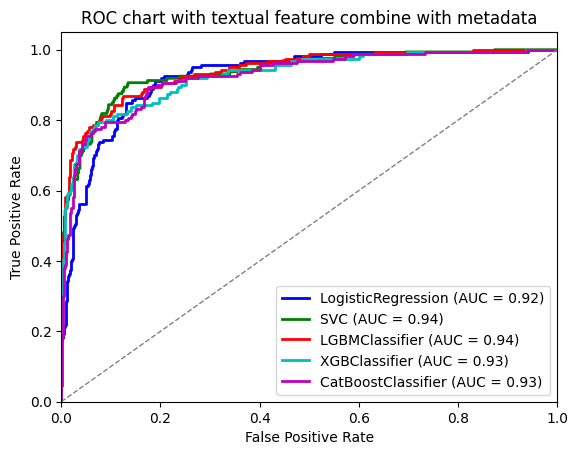

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Tạo một mảng chứa màu sắc cho các đường ROC
colors = ['b', 'g', 'r', 'c', 'm']

# Vẽ biểu đồ ROC-AUC cho từng mô hình trong danh sách
for i, model in enumerate(list_model):
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường ROC
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{list_model_name[i]} (AUC = {roc_auc:.2f})')

# Vẽ đường thẳng tham chiếu
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Cấu hình biểu đồ
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC chart with textual feature combine with metadata')
plt.legend(loc='lower right')

# Hiển thị biểu đồ ROC-AUC
plt.show()